In [1]:
import os
import sys
import cv2
import csv
import tqdm
import pandas as pd
import random
import numpy as np
import time
from skimage.morphology import skeletonize, medial_axis
from matplotlib import pyplot as plt

In [2]:
def grabcut2(croppedImage,x1,y1,x2,y2,buffer):
    image = croppedImage
    #x1, y1, x2, y2, *_ = outputs
    mask = np.zeros(image.shape[:2], dtype="uint8")
    rect = (buffer,buffer,abs(x1-x2),abs(y1-y2))
    fgModel = np.zeros((1, 65), dtype="float")
    bgModel = np.zeros((1, 65), dtype="float")
    (mask, bgModel, fgModel) = cv2.grabCut(image, mask, rect, bgModel,
        fgModel, iterCount=20, mode=cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    image2 = image*mask2[:,:,np.newaxis]
    return(image2)  

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.

In [ ]:
#def skel_worms(img,output):
    
    

In [3]:
csv_path = "C:/Users/benja/Desktop/NN_alive_dead_training_vids/csv_test_space/343_86_NN.csv"
im_path ="C:/Users/benja/Desktop/NN_alive_dead_training_vids/img_test_space/343_86_NN.png"
df = pd.read_csv(csv_path,names=('frame','label','x1', 'y1', 'w','h'))
df = df.drop([0])
print(df)
#df = int(df[['x1', 'y1', 'w', 'h']])
df['x1']= df['x1'].astype(int)
df['y1']= df['y1'].astype(int)
df['w']= df['w'].astype(int)
df['h']= df['h'].astype(int)

df['x2']=df[['x1','w']].sum(axis=1)
df['y2']=df[['y1','h']].sum(axis=1)
df = df[['x1', 'y1', 'x2', 'y2']]#.astype(int)
df = np.asarray(df)

print(df)
#unique = df["frame"].unique()



   frame label    x1   y1   w   h
1     86  worm   806  821  57  29
2     86  worm   937  681  31  46
3     86  worm   783  647  55  21
4     86  worm  1082  583  25  48
5     86  worm   846  588  52  20
6     86  worm   863  547  30  41
7     86  worm  1117  518  18  61
8     86  worm  1081  474  53  21
9     86  worm   876  457  41  37
10    86  worm  1113  419  33  39
11    86  worm  1026  412  52  25
12    86  worm   914  335  55  24
13    86  worm   853  288  61  18
14    86  worm  1223  169  56  32
[[ 806  821  863  850]
 [ 937  681  968  727]
 [ 783  647  838  668]
 [1082  583 1107  631]
 [ 846  588  898  608]
 [ 863  547  893  588]
 [1117  518 1135  579]
 [1081  474 1134  495]
 [ 876  457  917  494]
 [1113  419 1146  458]
 [1026  412 1078  437]
 [ 914  335  969  359]
 [ 853  288  914  306]
 [1223  169 1279  201]]


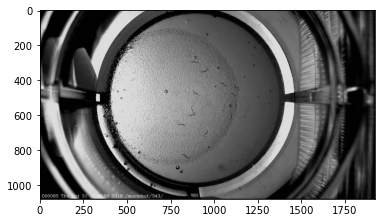

In [4]:
img_base = cv2.imread(im_path)
plt.imshow(img_base)
df = np.asarray(df)
  

In [ ]:
df = np.asarray(df)
for output in df:
    #print(output)
    #output = [int(n) for n in output]
    x1, y1, x2, y2, *_ = output
    croppedLarge = img_base[(y1-10):(y2+10),(x1-10):(x2+10)]
    thresh = grabcut2(croppedLarge, x1, y1, x2, y2) 
    revthresh = cv2.bitwise_not(thresh)
    im_bw = cv2.threshold(revthresh, 254, 255, cv2.THRESH_BINARY)[1]
    im_bw_inv = cv2.bitwise_not(im_bw)
    skeleton = skeletonize(im_bw_inv)
    skeleton_inv = cv2.cvtColor(skeleton, cv2.COLOR_BGR2GRAY)
    length = cv2.countNonZero(skeleton_inv)
    im_bw_inv_grayscale = cv2.cvtColor(im_bw_inv, cv2.COLOR_BGR2GRAY)
    area = cv2.countNonZero(im_bw_inv_grayscale)
    skel_padded = cv2.copyMakeBorder(skeleton_inv, (y1-10), (1080-(y2+10)), (x1-10), (1920-(x2+10)), cv2.BORDER_CONSTANT,value=0)
    skel_padded_inv = cv2.bitwise_not(skel_padded)
    skel_padded_inv= cv2.cvtColor(skel_padded_inv, cv2.COLOR_GRAY2BGR)
    skel_padded_inv[np.all(skel_padded_inv != [255,255,255], axis=-1)] = [255,0,0]
    comp_image = cv2.bitwise_and(img_base, skel_padded_inv)
    #img_base = comp_image

In [ ]:

im_bw.shape
im_bw[np.all(im_bw != [255,255,255], axis=-1)] = [255,0,0]
comp_image = cv2.bitwise_and(croppedLarge, im_bw)
plt.imshow(comp_image)


In [ ]:

for output in df:
    #print(output)
    #output = [int(n) for n in output]
    x1, y1, x2, y2, *_ = output
    # Draw rectangles
    cv2.rectangle(img_base, (x1,y1), (x2,y2), (255,255,0), 2)
    
cv2.imwrite("C:/Users/benja/Desktop/NN_alive_dead_training_vids/skeletonworms.png", img_base)   

In [ ]:
skel_inv = cv2.bitwise_not(skeleton_inv)
skel_inv= cv2.cvtColor(skel_inv, cv2.COLOR_GRAY2BGR)
skel_inv[np.all(skel_inv != [255,255,255], axis=-1)] = [255,0,0]
comp_imagesmall = cv2.bitwise_and(croppedLarge, skel_inv)


plt.imshow(comp_imagesmall)

In [ ]:
r = 200.0 / comp_imagesmall.shape[1]
dim = (200, int(comp_imagesmall.shape[0] * r))
resized = cv2.resize(comp_imagesmall, dim, interpolation = cv2.INTER_AREA)
plt.imshow(resized)
print(dim,r)

In [ ]:
bw_bullshit = cv2.cvtColor(im_bw_inv, cv2.COLOR_BGR2GRAY)
skelmed,distance = medial_axis(bw_bullshit, return_distance=True)
dist_on_skel = skelmed*distance
#print(skelmed.type)
#skel_inv = cv2.bitwise_not(skelmed)
print(skelmed.shape)
plt.imshow(dist_on_skel)

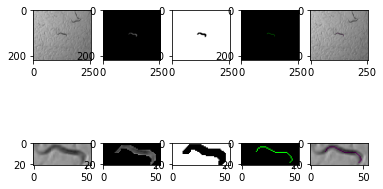

In [5]:
x1, y1, x2, y2, *_ = df[2,:]
buffer = 100
croppedLarge = img_base[(y1-buffer):(y2+buffer),(x1-buffer):(x2+buffer)]
thresh = grabcut2(croppedLarge, x1, y1, x2, y2, buffer) 
revthresh = cv2.bitwise_not(thresh)
im_bw = cv2.threshold(revthresh, 254, 255, cv2.THRESH_BINARY)[1]
kernel = np.ones((3,3),np.uint8)
im_bw = cv2.erode(im_bw,kernel,iterations = 1)

im_bw_inv = cv2.bitwise_not(im_bw)
skeleton = skeletonize(im_bw_inv)
skeleton_inv = cv2.bitwise_not(skeleton)
#length = cv2.countNonZero(skeleton_inv)
#im_bw_inv_grayscale = cv2.cvtColor(im_bw_inv, cv2.COLOR_BGR2GRAY)
#area = cv2.countNonZero(im_bw_inv_grayscale)
#skel_padded = cv2.copyMakeBorder(skeleton_inv, (y1-10), (1080-(y2+10)), (x1-10), (1920-(x2+10)), cv2.BORDER_CONSTANT,value=0)
#skel_padded_inv = cv2.bitwise_not(skel_padded)
#skel_padded_inv= cv2.cvtColor(skel_padded_inv, cv2.COLOR_GRAY2BGR)
#skel_padded_inv[np.all(skel_padded_inv != [255,255,255], axis=-1)] = [255,0,0]
comp_image = cv2.bitwise_and(croppedLarge, skeleton_inv)
plt.ioff()

f, axarr = plt.subplots(2,5) 
#plt.imshow(im_bw)
axarr[0,0].imshow(croppedLarge)
axarr[0,1].imshow(thresh)
axarr[0,2].imshow(im_bw)
axarr[0,3].imshow(skeleton)
axarr[0,4].imshow(comp_image)

height, width, channels = croppedLarge.shape

croppedLarge2 = croppedLarge[(buffer):(height-buffer),(buffer):(width-buffer)]
thresh2 = thresh[(buffer):(height-buffer),(buffer):(width-buffer)]
im_bw2 = im_bw[(buffer):(height-buffer),(buffer):(width-buffer)]
skeleton2 = skeleton[(buffer):(height-buffer),(buffer):(width-buffer)]
comp_image2 = comp_image[(buffer):(height-buffer),(buffer):(width-buffer)]
axarr[1,0].imshow(croppedLarge2)
axarr[1,1].imshow(thresh2)
axarr[1,2].imshow(im_bw2)
axarr[1,3].imshow(skeleton2)
axarr[1,4].imshow(comp_image2)




plt.savefig("C:/Users/benja/Desktop/NN_alive_dead_training_vids/test_multi.png")

In [ ]:
height, width, channels = croppedLarge.shape
plt.imshow(croppedLarge[(buffer):(height-buffer),(buffer):(width-buffer)])


In [3]:
import torch
print(torch.__version__)


1.7.1


In [1]:
import torchvision

In [2]:
print(torchvision.__version__)


0.8.2


In [5]:
print(python.__version__)


NameError: name 'python' is not defined